In [22]:
from setup_notebook import setup_project_path
setup_project_path()

In [23]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from datetime import datetime, date, timedelta
import os
import numpy as np
from scipy.stats import lognorm, loguniform, norm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate
import boto3
from io import StringIO
pd.set_option('display.max_columns',100)

## Load Data

In [25]:
data_dir = PROCESSED_DATA_DIR
models_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [26]:
df_train_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_train_360_days.csv'))
df_test_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_360_days.csv'))
df_oov_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_360_days.csv'))

In [27]:
df_train_360[df_train_360.accounts_group=='2021-12_Uganda_SHS Entry-Level_Iganga_Sun King Home 120 EasyBuy']

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age
47145,2021-12_Uganda_SHS Entry-Level_Iganga_Sun King...,7,135.85894,371,0.156767,0.261685,0.33593,0.513145,0.711295,0.848832,NaN,NaN,NaN,NaN,2.4816,1.7976,1.4735,1.0799,0.9846,0.8754,NaN,NaN,NaN,NaN,0.0,4.0,11.0,21.0,34.0,40.0,NaN,NaN,NaN,NaN,0.142857,0.166667,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.142857,NaN,NaN,NaN,NaN,0.0,0.142857,0.142857,0.142857,0.285714,0.428571,NaN,NaN,NaN,NaN,0.285714,0.285714,0.0,0.142857,0.0,0.142857,NaN,NaN,NaN,NaN,0.991967,1146.222065,1155.50423,2021-12,Uganda,SHS Entry-Level,Iganga,Sun King Home 120 EasyBuy,44,360


In [28]:
df_train_360.accounts_group.sample(frac=0.001).tolist()

['2020-07_Kenya_Lanterns_Brigadier_Sun King Pro EasyBuy',
 '2018-01_Uganda_Lanterns_Lira_Sun King Boom EasyBuy',
 '2021-10_Myanmar (Burma)_SHS Entry-Level_Gyobingauk_Sun King Home 120 EasyBuy',
 '2021-09_Kenya_SHS Entry-Level Upgrade_Eldoret_Sun King Home 120 EasyBuy',
 '2017-09_Myanmar (Burma)_SHS Entry-Level_Minbu_Sun King Home 120 EasyBuy',
 '2020-08_Kenya_Lanterns_Kajiado_Sun King Pro EasyBuy',
 '2022-02_Kenya_SHS Entry-Level Upgrade_Eldoret_Sun King Home 120 EasyBuy',
 '2020-03_Kenya_SHS with TV Upgrade_Katito_Sun King Home 400 Easybuy GSM',
 '2020-11_Kenya_SHS with TV_CBD_Sun King Home 400 Easybuy GSM',
 '2019-04_Kenya_SHS with TV Upgrade_Mombasa_Sun King Home 400 Easybuy GSM',
 '2020-05_Myanmar (Burma)_SHS without TV_Aungpan_Sun King Home 400 Easybuy GSM',
 '2021-02_Kenya_SHS with Stove_Meru_Sun King Home 60 EasyBuy',
 '2021-04_Kenya_SHS Entry-Level Upgrade_Narok_Sun King Home 60 EasyBuy',
 '2021-06_Kenya_Lanterns_Rabuor_Sun King Boom EasyBuy',
 '2020-02_Tanzania_Lanterns_Singid

In [29]:
df_test_360.shape

(8987, 84)

In [30]:
df_train_360.shape

(50926, 84)

In [31]:
df_train_360

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age
0,2021-09_Kenya_SHS Entry-Level Upgrade_Maralal_...,10,45.392320,371,0.055926,0.108556,0.161303,0.293367,0.407198,0.526593,0.615290,NaN,NaN,NaN,0.8850,0.7455,0.7074,0.6172,0.5635,0.5430,0.6152,NaN,NaN,NaN,2.0,9.0,20.0,55.0,94.0,125.0,170.0,NaN,NaN,NaN,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.100000,0.100000,0.300000,0.100000,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.200000,NaN,NaN,NaN,0.200000,0.600000,0.600000,0.300000,0.500000,0.800000,0.300000,NaN,NaN,NaN,0.823681,952.666430,1156.596340,2021-09,Kenya,SHS Entry-Level Upgrade,Maralal,Sun King Home 60 EasyBuy,47,450
1,2021-10_Nigeria_Fans_Epe_Sun King Fan EasyBuy,53,644.849516,371,0.089985,0.157837,0.217453,0.423004,0.608091,0.770864,0.883200,0.923585,0.941364,0.946081,1.4226,1.0829,0.9526,0.8891,0.8407,0.7940,0.8832,0.9235,0.9413,0.9460,0.0,2.0,4.0,24.0,39.0,64.0,83.0,97.0,105.0,107.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.056604,0.037736,0.094340,0.113208,0.169811,0.113208,0.132075,0.113208,0.0,0.0,0.0,0.000000,0.000000,0.132075,0.509434,0.754717,0.830189,0.849057,0.037736,0.188679,0.226415,0.113208,0.301887,0.320755,0.283019,0.169811,0.150943,0.132075,0.955878,6410.533754,6706.435083,2021-10,Nigeria,Fans,Epe,Sun King Fan EasyBuy,46,720
2,2021-12_Kenya_Phones_Brigadier_Tecno Spark 8,3,92.947287,371,0.056610,0.121628,0.182884,0.365634,0.475275,0.560273,0.645604,0.697120,0.755811,0.814585,0.8959,0.8353,0.8020,0.7693,0.6577,0.5777,0.6456,0.6971,0.7558,0.8145,2.0,9.0,17.0,41.0,48.0,109.0,121.0,132.0,141.0,149.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.333333,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,1.000000,0.333333,0.666667,0.666667,0.333333,0.333333,0.836996,444.996028,531.658488,2021-12,Kenya,Phones,Brigadier,Tecno Spark 8,44,720
3,2021-02_Kenya_SHS with TV Upgrade_Kiambu_Sun K...,2,18.238912,553,0.045788,0.097070,0.148535,0.289835,0.436722,0.578755,0.731502,0.869963,NaN,NaN,1.0869,1.0000,0.9771,0.9147,0.9066,0.8951,0.9015,0.8911,NaN,NaN,0.0,1.0,3.0,15.0,26.0,38.0,45.0,60.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

## More Feature Engineering

In [32]:
def feature_engineering(df_train, df_test, df_oov):
    
    # Creating column for Unlock price
    df_train['unlock_price_usd'] = df_train['upfront_price_usd'] + df_train['total_follow_on_revenue_usd']
    df_test['unlock_price_usd'] = df_test['upfront_price_usd'] + df_test['total_follow_on_revenue_usd']
    df_oov['unlock_price_usd'] = df_oov['upfront_price_usd'] + df_oov['total_follow_on_revenue_usd']

    # Calculating averge unlock and upfront price

    df_train['avg_upfront_price_usd'] = np.round((df_train['upfront_price_usd']/df_train['count_units']),0)
    df_test['avg_upfront_price_usd'] = np.round((df_test['upfront_price_usd']/df_test['count_units']),0)
    df_oov['avg_upfront_price_usd'] = np.round((df_oov['upfront_price_usd']/df_oov['count_units']),0)
    
    df_train['avg_unlock_price_usd'] = np.round((df_train['unlock_price_usd']/df_train['count_units']),0)
    df_test['avg_unlock_price_usd'] = np.round((df_test['unlock_price_usd']/df_test['count_units']),0)
    df_oov['avg_unlock_price_usd'] = np.round((df_oov['unlock_price_usd']/df_oov['count_units']),0)

    # Removing unnecessary columns
    #cols_to_remove = [col for col in df_train.columns if ('repayment_speed_' in col)]
    cols_to_remove = []
    cols_to_remove.append('upfront_price_usd')
    cols_to_remove.append('unlock_price_usd')

    print('columns to remove: ',cols_to_remove)
    
    df_train.drop(cols_to_remove, axis=1, inplace=True)
    df_test.drop(cols_to_remove, axis=1, inplace=True)
    df_oov.drop(cols_to_remove, axis=1, inplace=True)
    
    print('Sample from train data------------')
    print(df_train.sample(1))
    
    print('Sample from test data------------')
    print(df_test.sample(1))

    df_train = df_train.reset_index().drop(columns = 'index')
    df_test = df_test.reset_index().drop(columns = 'index')
    df_oov = df_oov.reset_index().drop(columns = 'index')
    
    return df_train, df_test, df_oov

In [33]:
df_train, df_test, df_oov = feature_engineering(df_train_360, df_test_360, df_oov_360)

columns to remove:  ['upfront_price_usd', 'unlock_price_usd']
Sample from train data------------
                                          accounts_group  count_units  \
39436  2021-02_Kenya_Lanterns_Nyadorera_Sun King Boom...          342   

       avg_planned_repayment_days   frr_30    frr_60    frr_90   frr_180  \
39436                         289  0.07341  0.144914  0.210347  0.384526   

        frr_270   frr_360   frr_450   frr_540   frr_630   frr_720  \
39436  0.547468  0.683126  0.763951  0.817592  0.857933  0.888687   

       repayment_speed_30  repayment_speed_60  repayment_speed_90  \
39436              0.8976              0.7689              0.7127   

       repayment_speed_180  repayment_speed_270  repayment_speed_360  \
39436               0.6251               0.5854               0.6853   

       repayment_speed_450  repayment_speed_540  repayment_speed_630  \
39436               0.7653               0.8178               0.8579   

       repayment_speed_720  avg_cum

In [34]:
import pandas as pd
import numpy as np
from typing import List

# --- SETTINGS ---
BACKTEST_POINTS = [30,60,90,180,270,360,450,540,630,720]

# Prefix groups seen in your table
PREFIXES = [
    "frr",
    "repayment_speed",
    "avg_cum_days_disabled",
    "at_risk_rate",
    "disabled_gt_two_week_rate",
    "unlocked_rate",
    "disabled_rate"
]

# Static columns to always include
STATIC_COLS = [
    "accounts_group", "count_units", "avg_planned_repayment_days",
    "reg_month", "country", "product_group", "area", "primary_product",
    "age_in_months", "cohort_age", "avg_upfront_price_usd", "avg_unlock_price_usd"
]

SENTINEL = -999.0   # value to fill masked-out future features with


def suffix_col(prefix: str, bt: int) -> str:
    return f"{prefix}_{bt}"

def all_feature_cols(prefixes: List[str], bts: List[int]) -> List[str]:
    cols = []
    for p in prefixes:
        for bt in bts:
            cols.append(suffix_col(p, bt))
    return cols

ALL_BT_COLS = all_feature_cols(PREFIXES, BACKTEST_POINTS)


def make_view(df: pd.DataFrame, max_bt: int, fill_sentinel: float = SENTINEL, override_cohort_age: bool = True):
    """
    Return a copy of df where features for backtesting points > max_bt are masked (set to sentinel),
    and for each bt we add a presence flag column like `frr_present_450`.
    If override_cohort_age=True, set cohort_age = min(original, max_bt) to simulate the view.
    """
    df_view = df.copy(deep=True)

    # ensure all expected columns exist (if some missing in the raw df)
    for col in ALL_BT_COLS:
        if col not in df_view.columns:
            df_view[col] = np.nan

    # Add presence flags for each backtesting point (1 if that bt col is non-null and cohort_age >= bt)
    for bt in BACKTEST_POINTS:
        # create a presence flag based on existing value & cohort_age
        col_any = False
        for p in PREFIXES:
            if not df_view[suffix_col(p, bt)].isnull().all():
                col_any = True
                break

        flag_col = f"bt_present_{bt}"
        # If original data may have NaNs for some columns, we consider cohort_age to decide presence
        df_view[flag_col] = ((df_view["cohort_age"] >= bt) & col_any).astype(int)

    # Mask features beyond max_bt
    for bt in BACKTEST_POINTS:
        if bt > max_bt:
            for p in PREFIXES:
                c = suffix_col(p, bt)
                # mask value
                df_view[c] = df_view[c].fillna(fill_sentinel)   # convert NaN to sentinel too
                df_view.loc[:, c] = fill_sentinel
        else:
            # ensure missing values within allowed bt are handled (fillna with sentinel or better: keep NaN)
            # We recommend filling with sentinel for LightGBM
            for p in PREFIXES:
                c = suffix_col(p, bt)
                df_view[c] = df_view[c].fillna(fill_sentinel)

    # optionally override cohort_age to reflect the view (so the model sees 'age at view')
    if override_cohort_age:
        df_view["cohort_age"] = df_view["cohort_age"].clip(upper=max_bt)

    # ensure static cols exist
    for sc in STATIC_COLS:
        if sc not in df_view.columns:
            df_view[sc] = np.nan

    # Final column order for model
    feature_cols = STATIC_COLS + ALL_BT_COLS + [f"bt_present_{bt}" for bt in BACKTEST_POINTS]
    # If you prefer to drop textual fields before modelling, leave only numeric static cols:
    # numeric_static = ["count_units", "avg_planned_repayment_days", "age_in_months", "cohort_age","avg_upfront_price_usd","avg_unlock_price_usd"]
    # feature_cols = numeric_static + ALL_BT_COLS + [f"bt_present_{bt}" for bt in BACKTEST_POINTS]

    return df_view[feature_cols]


In [35]:
# # assume `df` is your full dataframe (the sample rows you pasted)
# df = df_train.copy()

# # filter cohorts with real extended data available
# mask_has_450 = df["cohort_age"] >= 450
# df_with_450 = df[mask_has_450].reset_index(drop=True)

# # Construct the two views
# X450 = make_view(df_with_450, max_bt=450, fill_sentinel=SENTINEL, override_cohort_age=True)
# X360 = make_view(df_with_450, max_bt=360, fill_sentinel=SENTINEL, override_cohort_age=True)

# # target (true label) for training:
# y = df_with_450["frr_3_years"].values   # or "actual_fr" depending on training target

# print("X450.shape:", X450.shape)
# print("X360.shape:", X360.shape)
# print("y.shape:", y.shape)


In [36]:
# assume `df` is your full dataframe (the sample rows you pasted)
df = df_train.copy()

# choose horizons you want to include
horizons = [360, 450, 540, 630, 720]   # extend this list as needed

# filter cohorts that are mature enough for the max horizon
max_h = max(horizons)
mask_has_full = df["cohort_age"] >= max_h
df_with_full = df[mask_has_full].reset_index(drop=True)

# build stacked X, y, weights
X_list, y_list, w_list = [], [], []

# define a simple weight decay schedule

# hard-coded weight map
horizon_weights = {
    360: 5.0,   # anchor strongly
    450: 3.0,   # medium anchor
    540: 1.5,   # moderate
    630: 1.0,    # lowest
    720: 0.5
}

for h in horizons:
    X_h = make_view(df_with_full, max_bt=h, fill_sentinel=SENTINEL, override_cohort_age=True)
    y_h = df_with_full["frr_3_years"].values  # or "actual_fr" depending on training target
    w_h = np.ones(len(y_h)) * horizon_weights[h]

    X_list.append(X_h)
    y_list.append(y_h)
    w_list.append(w_h)

# stack them
X_stack = pd.concat(X_list, axis=0).reset_index(drop=True)
y_stack = np.concatenate(y_list, axis=0)
weights = np.concatenate(w_list, axis=0)

# shuffle to avoid ordering bias
from sklearn.utils import shuffle
X_stack, y_stack, weights = shuffle(X_stack, y_stack, weights, random_state=42)

print("X_stack.shape:", X_stack.shape)
print("y_stack.shape:", y_stack.shape)
print("weights.shape:", weights.shape)


X_stack.shape: (152275, 92)
y_stack.shape: (152275,)
weights.shape: (152275,)


## Weightage

In [37]:
# # stack them
# # X_stack = pd.concat([X450, X360], axis=0).reset_index(drop=True)
# # y_stack = np.concatenate([y, y], axis=0)

# X_stack = pd.concat([X360, X450, X540, X630], axis=0).reset_index(drop=True)
# y_stack = np.concatenate([y360, y450, y540, y630], axis=0)

# # build sample weights: weight real extended = 1.0, truncated pseudo = 0.3
# # weights = np.concatenate([
# #     np.ones(len(y)) * 10.0,                # weights for extended rows
# #     np.ones(len(y)) * 3.0         # weights for truncated rows
# # ], axis=0)

# weights = np.concatenate([
#     np.ones(len(y360)) * 5.0,   # anchor hard at 360
#     np.ones(len(y450)) * 3.0,   # also anchor at 450
#     np.ones(len(y540)) * 1.0,   # still included but lower importance
#     np.ones(len(y630)) * 0.5    # tail-end: allow some divergence
# ], axis=0)

# # optionally shuffle
# from sklearn.utils import shuffle
# X_stack, y_stack, weights = shuffle(X_stack, y_stack, weights, random_state=42)


In [38]:
X_stack

,accounts_group,count_units,avg_planned_repayment_days,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
139888,2019-10_Kenya_Lanterns_Nyamira_Sun King Pro Ea...,127,279,2019-10,Kenya,Lanterns,Nyamira,Sun King Pro EasyBuy,70,720,4.0,43.0,0.085892,0.163127,0.233956,0.433023,0.621985,0.755137,0.826826,0.865255,0.888046,0.895055,1.0194,0.8401,0.7694,0.6832,0.6455,0.7551,0.8268,0.8652,0.8880,0.8950,2.0,7.0,14.0,36.0,66.0,96.0,121.0,136.0,150.0,157.0,0.133858,0.078740,0.039370,0.039370,0.033613,0.035294,0.034483,0.046512,0.06250,0.071429,0.015748,0.055118,0.070866,0.125984,0.133858,0.118110,0.141732,0.181102,0.141732,0.173228,0.0,0.000000,0.000000,0.000000,0.062992,0.330709,0.543307,0.661417,0.748031,0.779528,0.228346,0.299213,0.291339,0.330709,0.377953,0.377953,0.291339,0.236220,0.196850,0.188976,1,1,1,1,1,1,1,1,1,1
80084,2021-10_Kenya_SHS with TV_Oyugis_Sun King Home...,17,656,2021-10,Kenya,SHS with TV,Oyugis,Sun King Home 400 Easybuy GSM,46,540,57.0,617.0,0.034041,0.070252,0.107189,0.208616,0.300153,0.394197,0.487536,0.581651,-999.000000,-999.000000,0.9643,0.8636,0.8414,0.7856,0.7435,0.7275,0.7170,0.7110,-999.0000,-999.0000,3.0,9.0,16.0,38.0,63.0,91.0,117.0,139.0,-999.0,-999.0,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.00000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,-999.000000,-999.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,-999.000000,0.352941,0.176471,0.176471,0.235294,0.352941,0.294118,0.235294,0.411765,-999.000000,-999.000000,1,1,1,1,1,1,1,1,1,1
131556,2020-08_Kenya_Lanterns_Isiolo_Sun King Pro Eas...,28,280,2020-08,Kenya,Lanterns,Isiolo,Sun King Pro EasyBuy,60,720,4.0,42.0,0.133516,0.211486,0.292779,0.539264,0.758582,0.877307,0.921664,0.956367,0.962899,0.983752,1.5847,1.0893,0.9629,0.8509,0.7874,0.8773,0.9216,0.9563,0.9628,0.9837,0.0,2.0,6.0,22.0,39.0,60.0,75.0,99.0,107.0,120.0,0.035714,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.035714,0.000000,0.071429,0.142857,0.071429,0.142857,0.071429,0.107143,0.035714,0.0,0.000000,0.000000,0.000000,0.071429,0.571429,0.750000,0.785714,0.857143,0.892857,0.035714,0.107143,0.107143,0.178571,0.285714,0.178571,0.214286,0.178571,0.142857,0.071429,1,1,1,1,1,1,1,1,1,1
148611,2021-07_Nigeria_SHS without TV_Ilorin_Sun King...,5,371,2021-07,Nigeria,SHS without TV,Ilorin,Sun King Home 400 EasyBuy,

In [39]:
X_stack = X_stack.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)

## Fit LightGBM

In [40]:
import lightgbm as lgb

train_data = lgb.Dataset(X_stack, label=y_stack, weight=weights)

# params = {
#     "objective": "regression",
#     "metric": "rmse",
#     "learning_rate": 0.03363666646274133,
#     "num_leaves": 185,
#     "min_data_in_leaf": 20,
#     "feature_fraction": 0.9,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "verbosity": -1
# }


params = {'objective': 'regression',
          'boosting_type': 'gbdt',
        'colsample_bytree': 0.48612837789165786, 
          'learning_rate': 0.03363666646274133, 
          'max_depth': 12, 
          'min_child_samples': 60, 
          'min_child_weight': 0.00013900522166696805, 
          'n_estimators': 1000, 
          'num_leaves': 185, 'reg_alpha': 0.9211614583138252, 
          'reg_lambda': 0.8749195072732266, 
          'subsample': 0.21685960679782915, 
          'subsample_for_bin': 154800}

bst = lgb.train(params, train_data, num_boost_round=1700)

bst.save_model("../models/regularized_lightgbm0.7.txt")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17713
[LightGBM] [Info] Number of data points in the train set: 152275, number of used features: 73
[LightGBM] [Info] Start training from score 0.851299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppose you have validation dataframe `df_val`
X_val = make_view(df_test, max_bt=df_test["cohort_age"].max())
X_val = X_val.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)
y_val = df_test["frr_3_years"].values

y_pred_val = bst.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse)

Validation RMSE: 0.05780275385017224


In [42]:
# # For rows that have at least 450 days
# df_check = df_with_450.copy()

# X360_check = make_view(df_check, max_bt=360)
# X450_check = make_view(df_check, max_bt=450)

# pred360 = bst.predict(X360_check.drop(['accounts_group','count_units',
#                        'reg_month','country','product_group','area','primary_product','age_in_months',
#  'cohort_age'], axis=1))
# pred450 = bst.predict(X450_check.drop(['accounts_group','count_units',
#                        'reg_month','country','product_group','area','primary_product','age_in_months',
#  'cohort_age'], axis=1))

# drift = np.mean((pred360 - pred450)**2)
# print("Mean squared drift between 360 and 450 views:", drift)

In [43]:
# pd.DataFrame({"pred360": pred360, "pred450": pred450})

In [44]:
X_val

,avg_planned_repayment_days,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
0,371,5.0,106.0,0.064103,0.173993,0.192766,0.325549,0.385989,0.442308,0.499084,0.566850,0.611722,0.611722,1.0144,1.1949,0.8453,0.6849,0.5342,0.4560,0.4990,0.5668,0.6117,0.6117,3.0,4.0,10.0,52.0,117.0,184.0,241.0,323.0,354.0,354.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1,1,1,1,1,1,1,1,1,1
1,362,5.0,145.0,0.051968,0.098924,0.136979,0.237104,0.319844,0.396994,-999.000000,-999.000000,-999.000000,-999.000000,0.8027,0.6631,0.5863,0.4869,0.4236,0.3981,-999.0000,-999.0000,-999.0000,-999.0000,3.0,11.0,22.0,60.0,100.0,143.0,-999.0,-999.0,-999.0,-999.0,0.264368,0.189655,0.132184,0.080460,0.057471,0.057803,-999.000000,-999.000000,-999.000000,-999.000000,0.034483,0.126437,0.201149,0.264368,0.379310,0.402299,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005747,-999.000000,-999.000000,-999.00000,-999.000000,0.396552,0.528736,0.557471,0.620690,0.729885,0.643678,-999.000000,-999.000000,-999.00000,-999.000000,1,1,1,1,1,1,0,0,0,0
2,378,12.0,101.0,0.097871,0.159684,0.221497,0.376030,0.530563,0.685096,0.820742,0.861951,0.913462,0.988324,2.2265,1.2635,1.0608,0.8245,0.7543,0.7207,0.8207,0.8619,0.9134,0.9883,0.0,0.0,0.0,5.0,40.0,69.0,93.0,138.0,140.0,174.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.250000,0.250000,0.375000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625000,0.625000,0.62500,0.875000,0.000000,0.125000,0.250000,0.375000,0.375000,0.500000,0.000000,0.250000,0.12500,0.000000,1,1,1,1,1,1,1,1,1,1
3,322,14.0,180.0,0.053016,0.097284,0.125926,0.195908,0.212840,0.263457,0.281623,-999.000000,-999.000000,-999.000000,0.7260,0.5781,0.4779,0.3567,0.2549,0.2634,0.2816,-999.0000,-999.0000,-999.0000,5.0,13.0,30.0,79.0,108.0,154.0,201.0,-999.0,-999.0,-999.0,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.666667,0.333333,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,-999.00000

In [45]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Suppose you have validation dataframe `df_val`
X_oov = make_view(df_oov, max_bt=df_test["cohort_age"].max())
X_oov = X_oov.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)
# y_val = df_test["frr_3_years"].values

y_pred_oov = bst.predict(X_oov)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

In [46]:
df_oov["predicted_frr"] = y_pred_oov

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math
results = {
    "rmse": math.sqrt(mean_squared_error(df_oov["frr_3_years"],y_pred_oov)),
    "mae": mean_absolute_error(df_oov["frr_3_years"], y_pred_oov),
    "mape": np.mean(np.abs((df_oov["frr_3_years"] - y_pred_oov) / y_pred_oov)),
    "r2": r2_score(df_oov["frr_3_years"], y_pred_oov),
    "qloss":  mean_pinball_loss(df_oov["frr_3_years"], y_pred_oov, alpha=0.5)
}

results

{'rmse': 0.059308048616645695,
 'mae': 0.030855000225925026,
 'mape': 0.05634728895933211,
 'r2': 0.8689996155365969,
 'qloss': 0.015427500112962513}

In [48]:
df_oov["predicted_frr"]  = df_oov["predicted_frr"].clip(lower=0, upper=1)
df_oov["frr_3_years"]  = df_oov["frr_3_years"].clip(lower=0, upper=1)
df_oov['predicted_revenue_USD'] = np.round(df_oov['predicted_frr']*df_oov['total_follow_on_revenue_usd'],2)

In [49]:
df_country = df_oov.groupby(["reg_month", "country"]).agg(
    total_fr=('actual_fr', "sum"),
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["actual_frr"] = np.round(df_country.total_fr/df_country.total_follow_on_price,4)
df_country["predicted_frr"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["deviation"] = (df_country.predicted_frr - df_country.actual_frr).round(4)

In [50]:
countries = ['Kenya','Nigeria','Tanzania','Uganda','Zambia']

In [51]:
df_country[df_country.country.isin(countries)].groupby("country").deviation.describe().reset_index()

,country,count,mean,std,min,25%,50%,75%,max
0,Kenya,6.0,0.001317,0.000943,0.0000,0.000750,0.00130,0.002000,0.0025
1,Nigeria,6.0,-0.001800,0.000648,-0.0026,-0.002250,-0.00175,-0.001550,-0.0008
2,Tanzania,6.0,0.007800,0.002760,0.0036,0.006325,0.00805,0.009925,0.0108
3,Uganda,6.0,0.015600,0.005689,0.0087,0.010800,0.01660,0.020150,0.0215
4,Zambia,6.0,-0.012917,0.006635,-0.0212,-0.017075,-0.01355,-0.009125,-0.0033


## OOV Visuals

0.0013


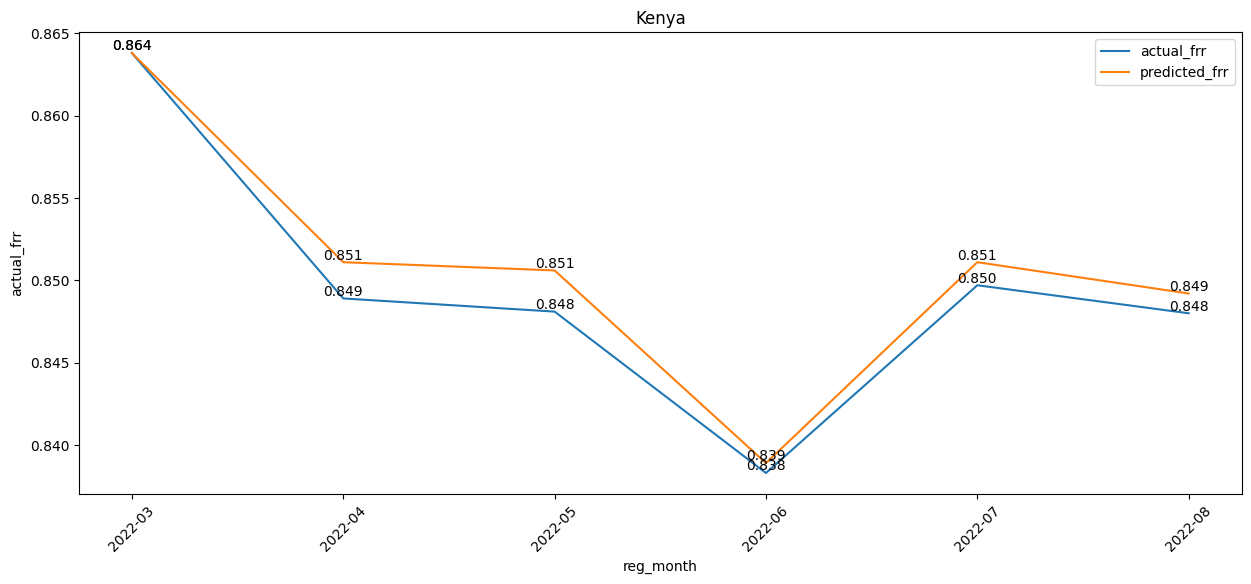

-0.0018


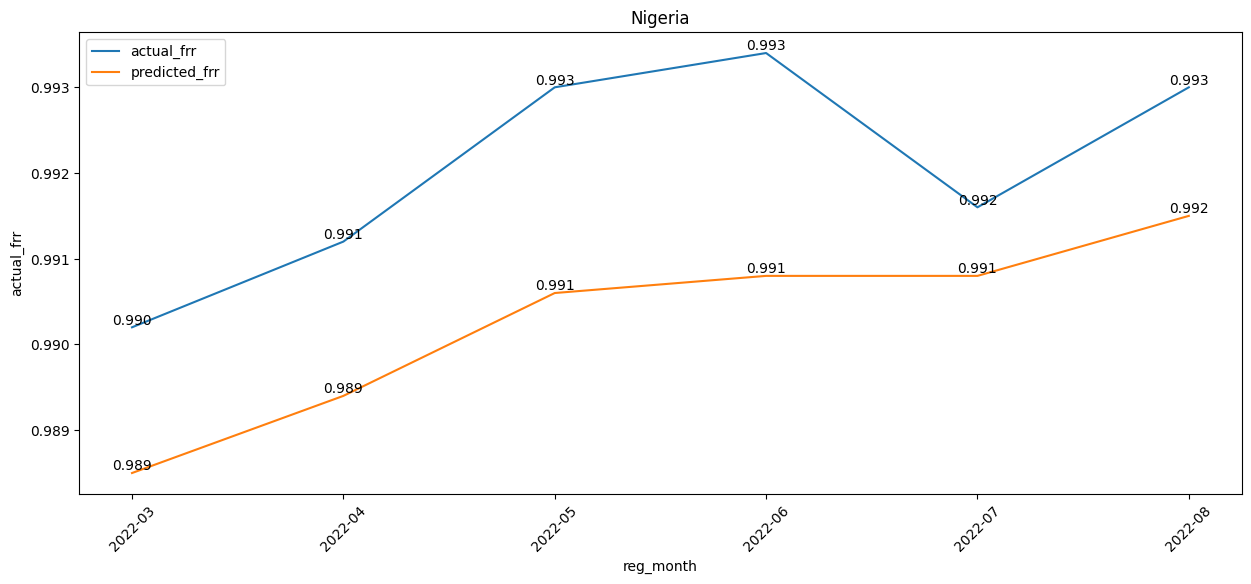

0.0078


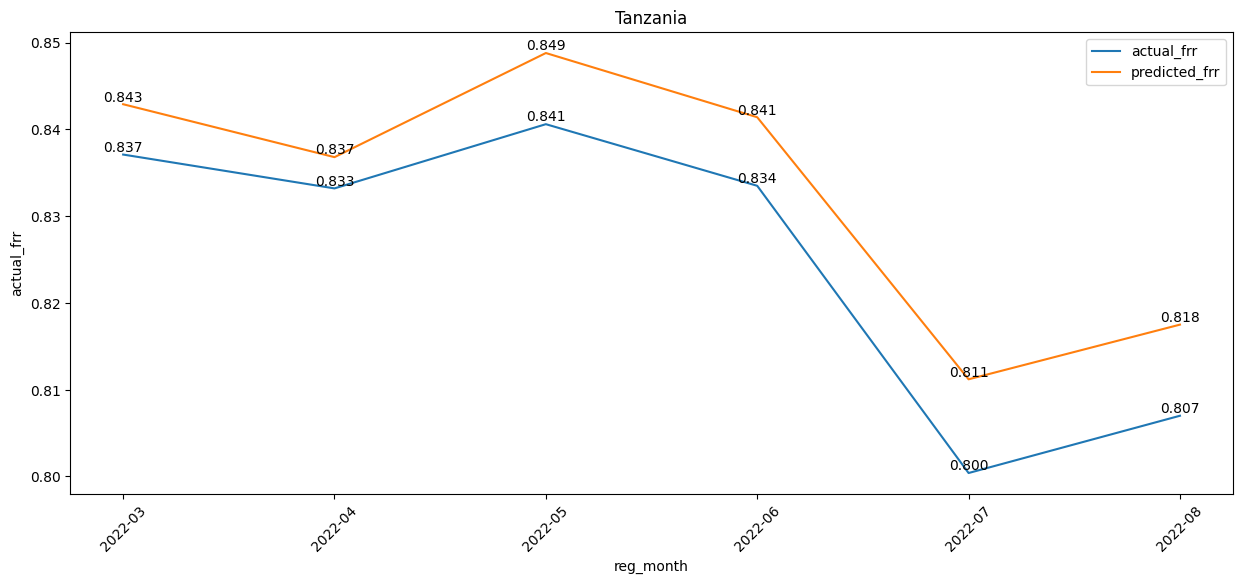

0.0156


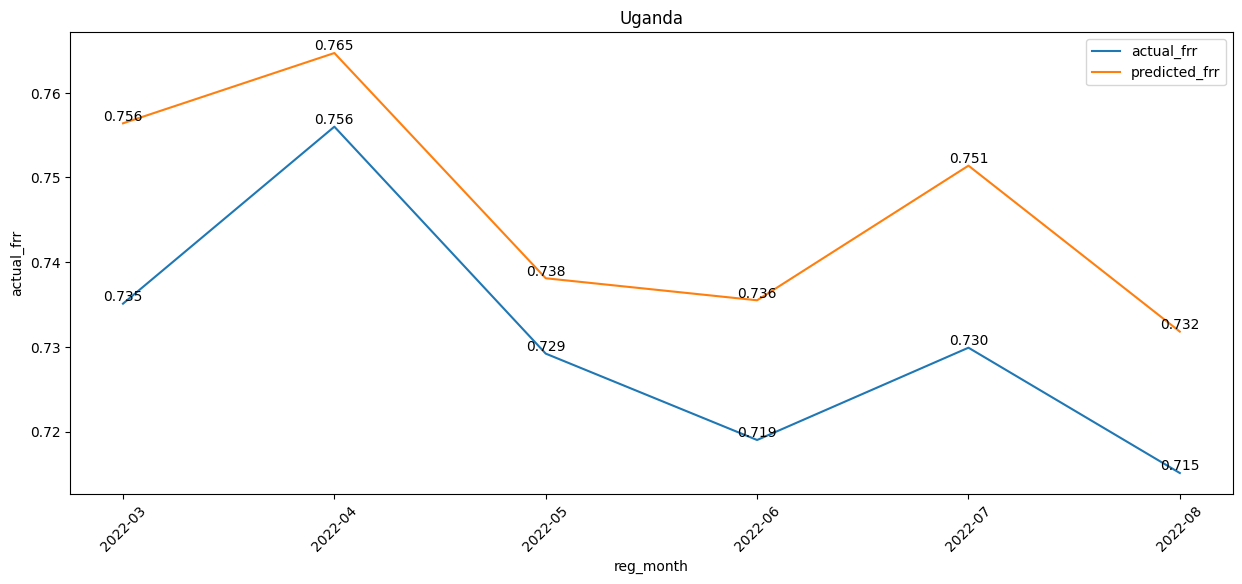

-0.0129


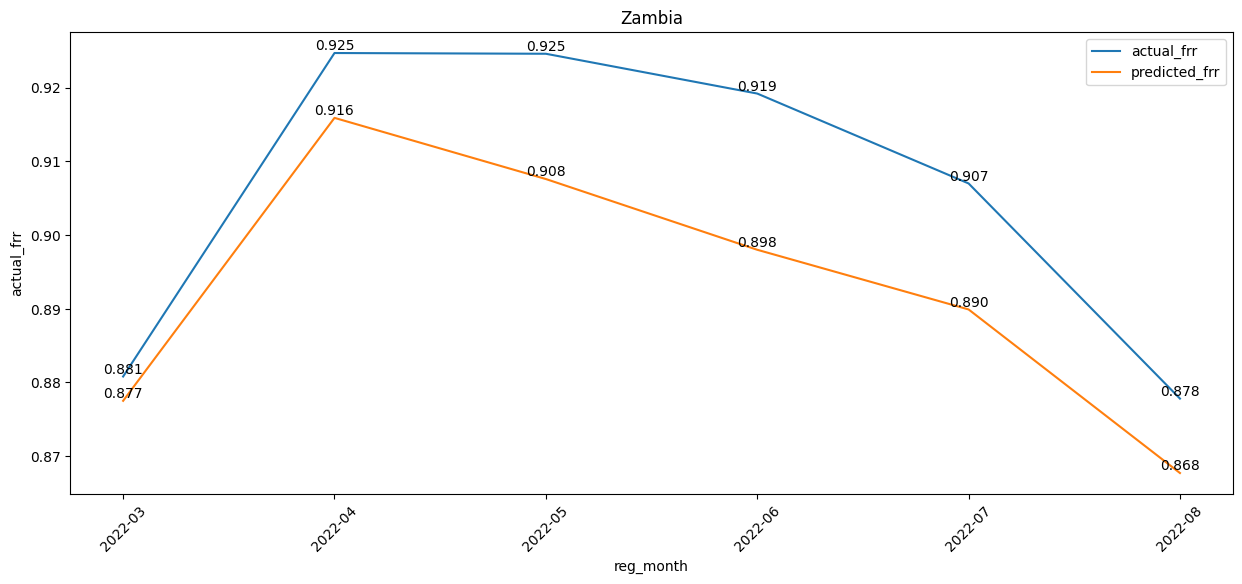

In [52]:
for country in countries:
    plt.figure(figsize=(15, 6))
    subset = df_country[(df_country.country==country)]
    deviation = (subset.predicted_frr - subset.actual_frr).mean().round(4)
    print(deviation)
    ax = sns.lineplot(data=subset, x="reg_month", y="actual_frr", label="actual_frr")
    for x, y in zip(subset["reg_month"], subset["actual_frr"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    
    ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr", label="predicted_frr")
    for x, y in zip(subset["reg_month"], subset["predicted_frr"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(f"{country}")
    plt.legend()
    plt.show()

## Inference

In [53]:
df_sep = pd.read_csv('../data/KPIs_data_processed_2025-08-01.csv',low_memory=False).rename({"cohort_age_backtesting": "cohort_age"}, axis=1)
print(df_sep.shape)

(1178935, 89)


In [54]:
df_sep = df_sep[df_sep.backtesting_limit==360]

In [55]:
df_sep_processed = make_view(df_sep, max_bt=df_sep["cohort_age"].max())

In [56]:
df_sep_processed

,accounts_group,count_units,avg_planned_repayment_days,reg_month,country,product_group,area,primary_product,age_in_months,cohort_age,avg_upfront_price_usd,avg_unlock_price_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,bt_present_30,bt_present_60,bt_present_90,bt_present_180,bt_present_270,bt_present_360,bt_present_450,bt_present_540,bt_present_630,bt_present_720
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,57,77,2016-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,114,720,7.0,30.0,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,1,1,1,1,1,1,1,1,1,1
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,18,77,2016-02,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,113,720,7.0,30.0,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,1,1,1,1,1,1,1,1,1,1
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,287,77,2016-02,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,113,720,7.0,30.0,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0.386760,0.268293,0.188153,0.163763,0.153310,0.128920,0.108014,0.062718,1,1,1,1,1,1,1,1,1,1
1015093,2016-03_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,114,77,2016-03,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,112,720,7.0,30.0,0.341451,0.566825,0.706045,

In [57]:
X_sep = df_sep_processed.drop(['accounts_group','count_units',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
 'cohort_age'], axis=1)

In [58]:
y_pred_sep = bst.predict(X_sep)

In [59]:
df_sep["predicted_frr"] = y_pred_sep

In [60]:
len(y_pred_sep)

163845

In [61]:
df_sep["date_uploaded"] = "2025-09-01"
df_sep["date_uploaded"] = pd.to_datetime(df_sep["date_uploaded"], format="%Y-%m-%d")
df_sep["reg_month"] = pd.to_datetime(df_sep["reg_month"], format="%Y-%m")

In [62]:
df_sep

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age,predicted_frr,date_uploaded
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.281498,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,114,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.966453,2025-09-01
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.352052,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,113,152.85,412.1688,412.168800,7.0,30.0,360,720,0.911240,2025-09-01
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7770.557718,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0.386760,0.268293,0.188153,0.163763,0.

In [63]:
df_sep['predicted_revenue_USD'] = np.round(df_sep['predicted_frr']*df_sep['total_follow_on_revenue_current_usd'],2)

In [64]:
df_sep

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age,predicted_frr,date_uploaded,predicted_revenue_USD
1015090,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.281498,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,114,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.966453,2025-09-01,1491.51
1015091,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.352052,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,113,152.85,412.1688,412.168800,7.0,30.0,360,720,0.911240,2025-09-01,444.09
1015092,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7770.557718,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0

In [65]:
df2 = df_sep.groupby(["country", "reg_month"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_USD", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df2["predicted_frr_updated"] = df2.predicted_fr/df2.total_fr
df2 = df2.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df2 = df2[df2.product_group.isin(products)]
# df2

In [66]:
df2[df2.country=="Kenya"][70:110]

,country,reg_month,count_average,predicted_frr_updated
171,Kenya,2021-11-01,41,0.864732
172,Kenya,2021-12-01,47,0.875448
173,Kenya,2022-01-01,46,0.878141
174,Kenya,2022-02-01,49,0.870432
175,Kenya,2022-03-01,49,0.868559
176,Kenya,2022-04-01,49,0.852801
177,Kenya,2022-05-01,56,0.855529
178,Kenya,2022-06-01,52,0.844058
179,Kenya,2022-07-01,53,0.856710
180,Kenya,2022-08-01,48,0.854486


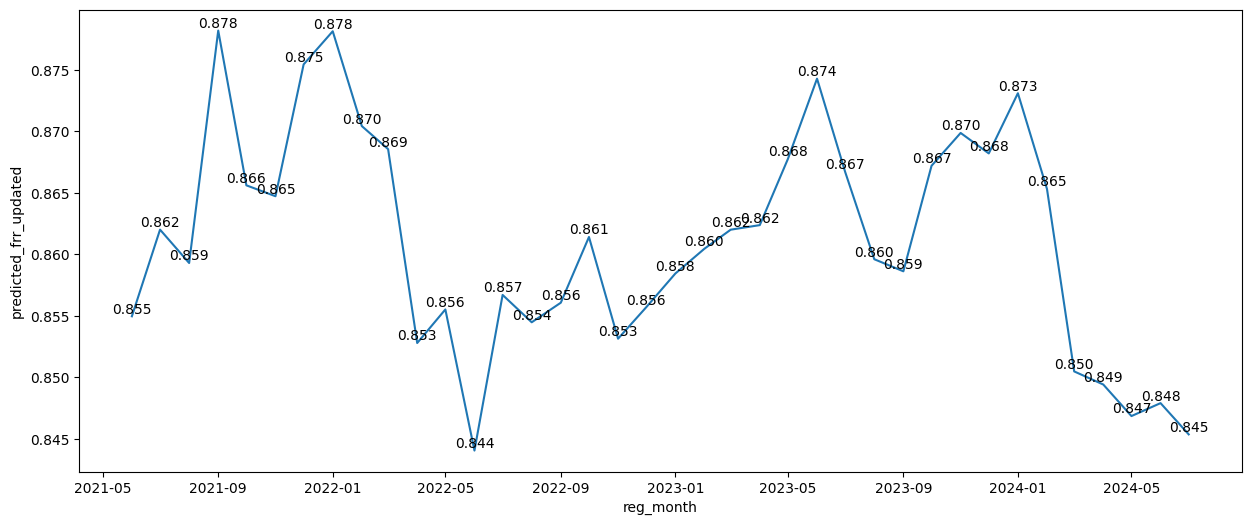

In [67]:
df2["reg_month"] = pd.to_datetime(df2["reg_month"])
plt.figure(figsize=(15, 6))
subset = df2[(df2["country"]=="Kenya") & (df2["reg_month"] >= "2021-06-01")]
ax = sns.lineplot(
    data=subset,
    x="reg_month",
    y="predicted_frr_updated"
)
for x, y in zip(subset["reg_month"], subset["predicted_frr_updated"]):
    ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")


